# Fine-Tunning LLaMA with Extended Dataset

In [ ]:
from sentence_transformers import SentenceTransformer, util
import json
from pathlib import Path
from tqdm import tqdm

# Load Sentence-BERT
model = SentenceTransformer("all-MiniLM-L6-v2")

# Paths
input_path = Path("/mnt/data/Sixth Implementation/telequad_v4_filtered_semantic_2048.jsonl")
output_path = Path("/mnt/data/Sixth Implementation/telequad_v4_filtered_semantic_2048_semantic_cleaned.jsonl")

# Similarity threshold
SIM_THRESHOLD = 0.6

def extract_context_and_answer(text):
    try:
        prompt_part, answer = text.split("[/INST]", 1)
        answer = answer.strip().replace("</s>", "")
        lines = prompt_part.splitlines()

        context_lines = []
        inside_context = False
        for line in lines:
            if line.strip().startswith("Context:"):
                inside_context = True
                context_lines.append(line.replace("Context:", "").strip())
                continue
            if line.strip().startswith("Question:"):
                break
            if inside_context:
                context_lines.append(line.strip())

        context = " ".join(context_lines)
        return context, answer
    except:
        return "", ""

# Apply filtering
kept = []
with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Filtering QA pairs"):
        obj = json.loads(line)
        text = obj.get("text", "")
        context, answer = extract_context_and_answer(text)

        if not context or not answer:
            continue

        context_emb = model.encode(context, convert_to_tensor=True)
        answer_emb = model.encode(answer, convert_to_tensor=True)

        similarity = util.cos_sim(context_emb, answer_emb).item()
        if similarity >= SIM_THRESHOLD:
            kept.append(obj)

# Save new dataset
with open(output_path, "w", encoding="utf-8") as f:
    for e in kept:
        f.write(json.dumps(e) + "\n")

print(f"✅ Filtered set saved: {output_path}")
print(f"Total kept examples: {len(kept)}")

In [ ]:
import json
from pathlib import Path
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# Configuration
MAX_TOKEN_LENGTH = 2048 

# Paths
input_path = Path("/mnt/data/Sixth Implementation/telequad_v4_reformatted.jsonl")
output_path = Path(f"/mnt/data/Sixth Implementation/telequad_v4_filtered_semantic_{MAX_TOKEN_LENGTH}.jsonl")

# Load tokenizer and sentence encoder
print(" Loading tokenizer and sentence encoder...")
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/llama2-model")
encoder = SentenceTransformer("all-MiniLM-L6-v2")
print("✅ Models loaded.")

# Prompt format
SYSTEM_PROMPT = (
    "You are a precise assistant. Extract the exact answer span from the context. "
    "Do not paraphrase, summarize, or add extra information. "
    "The answer must appear exactly in the context."
)

# Semantic Chunking Logic
def select_relevant_chunks(context: str, answer: str, window_size=150, stride=100) -> str:
    """
    Sliding window approach to ensure the answer appears in the selected chunk.
    """
    words = context.split()
    for start in range(0, len(words), stride):
        end = start + window_size
        chunk = " ".join(words[start:end])
        if answer in chunk:
            return chunk
        if end >= len(words):
            break
    return None

# Rebuild prompt from parts
def build_prompt(context: str, question: str, answer: str) -> str:
    user_prompt = (
        f"Context: {context}\n\n"
        f"Question: {question}\n"
        f"Answer:"
    )
    return f"<s>[INST] <<SYS>>\n{SYSTEM_PROMPT}\n<</SYS>>\n\n{user_prompt} [/INST] {answer}</s>"

# Process entries
print(" Processing and filtering entries...")
reformatted_entries = []
total_count = 0
filtered_out_count = 0


with open(input_path, "r", encoding="utf-8") as f:
    num_lines = sum(1 for line in f)

with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, total=num_lines, desc="Processing file"):
        total_count += 1
        try:
            entry = json.loads(line)
            original_text = entry["text"]

            # Parse the original text to extract context, question, and answer
            prompt_part, answer = original_text.split("[/INST]", 1)
            answer = answer.strip().replace("</s>", "")
            
            # Skip if answer is empty
            if not answer:
                continue

            lines = prompt_part.splitlines()
            context_lines, question = [], ""
            inside_context, inside_question = False, False

            for l in lines:
                stripped_line = l.strip()
                if stripped_line.startswith("Context:"):
                    inside_context = True
                    inside_question = False
                    # Capture text on the same line as "Context:"
                    context_lines.append(stripped_line.replace("Context:", "").strip())
                    continue
                elif stripped_line.startswith("Question:"):
                    inside_question = True
                    inside_context = False
                    # Capture text on the same line as "Question:"
                    question = stripped_line.replace("Question:", "").strip()
                    continue
                
                if inside_context:
                    context_lines.append(l) # Append original line to preserve formatting
                elif inside_question and not question:
                    question = stripped_line
            
            full_context = "\n".join(context_lines).strip()

            if not full_context or not question:
                continue

            # Tokenize and decide whether to shorten the context
            temp_prompt = build_prompt(full_context, question, answer)
            input_ids = tokenizer(temp_prompt)["input_ids"]

            final_context = full_context
            
            if len(input_ids) > MAX_TOKEN_LENGTH:
                short_context = select_relevant_chunks(full_context, answer, window_size=150, stride=100)
                
                if short_context is not None and answer in short_context:
                    final_context = short_context
                else:
                    filtered_out_count += 1
                    continue

            # Build the final, validated prompt and add it to our list
            final_prompt = build_prompt(final_context, question, answer)
            reformatted_entries.append({"text": final_prompt})

        except (ValueError, KeyError) as e:
            # Catch potential errors from malformed JSON lines or text splitting.
            print(f"Skipping malformed line {total_count}: {e}")
            continue

# Save output
print("💾 Saving the new dataset...")
with open(output_path, "w", encoding="utf-8") as f:
    for e in reformatted_entries:
        f.write(json.dumps(e) + "\n")

print("\n--- 📊 Processing Complete ---")
print(f"Total examples processed: {total_count}")
print(f"Examples kept for training: {len(reformatted_entries)}")
print(f"Examples filtered out (answer lost during chunking): {filtered_out_count}")
print(f"✅ Filtered and reformatted file saved to: {output_path}")

In [ ]:
import json
from pathlib import Path
from tqdm import tqdm
import re

# Paths
# The input is the dataset you've been using
input_path = Path("/mnt/data/Sixth Implementation/telequad_v4_filtered_semantic_2048.jsonl")
# The output is our new, clean "golden" dataset
output_path = Path("/mnt/data/Sixth Implementation/telequad_v4_golden.jsonl")

print(f"Input dataset: {input_path}")
print(f"Output dataset: {output_path}")

cleaned_entries = []

print("⏳ Reading and cleaning the dataset...")
with open(input_path, "r", encoding="utf-8") as f:
    for line in tqdm(f.readlines()):
        try:
            entry = json.loads(line)
            text = entry.get("text", "")
            
            # Split the entry into the prompt and the answer
            prompt_part, answer_part = text.split("[/INST]", 1)
            
            # Clean the original answer
            original_answer = answer_part.strip().replace("</s>", "")
            
            # The Cleaning Logic (CORRECTED)
            clean_answer = original_answer
            
            # Rebuild the text entry with the clean answer
            new_text = f"{prompt_part}[/INST] {clean_answer}</s>"
            cleaned_entries.append({"text": new_text})

        except (ValueError, KeyError) as e:
            print(f"Skipping malformed line: {e}")
            continue

print(f"💾 Saving {len(cleaned_entries)} cleaned entries to the golden dataset...")
with open(output_path, "w", encoding="utf-8") as f:
    for entry in cleaned_entries:
        f.write(json.dumps(entry) + "\n")

print("✅ Golden dataset created successfully!")

In [1]:
import torch
from pathlib import Path
import json
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Load and Combine Datasets
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

v4_path = "/mnt/data/Sixth Implementation/telequad_v4_golden.jsonl"

v4_data = load_jsonl(v4_path)

combined_data = v4_data  
dataset = Dataset.from_list(combined_data).shuffle(seed=42)

#  90/5/5 Split
split = dataset.train_test_split(test_size=0.10, seed=42)
val_test = split["test"].train_test_split(test_size=0.5, seed=42)
train_dataset = split["train"]
val_dataset = val_test["train"]
test_dataset = val_test["test"]

In [2]:
# Load Tokenizer
model_path = "/mnt/data/llama2-model"  
print("🔤 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token  # Padding with eos token

🔤 Loading tokenizer...


In [3]:
# Tokenize Data
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=2048
    )

train_dataset = train_dataset.map(tokenize, batched=True, num_proc=4, remove_columns=["text"])
val_dataset = val_dataset.map(tokenize, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/16399 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/911 [00:00<?, ? examples/s]

In [4]:
# Data Collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=64  # Padding efficiency boost
)

In [5]:
# Load Model with LoRA
print("🧠 Loading LLaMA-2 with LoRA...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16
)

base_model = prepare_model_for_kbit_training(base_model)
base_model.gradient_checkpointing_enable()
base_model.config.use_cache = False

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

🧠 Loading LLaMA-2 with LoRA...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


In [6]:
output_dir = "/mnt/data/llama2_qa_lora_output6"

In [7]:
# Training Arguments
print("⚙️ Setting up training...")
args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=6,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    gradient_accumulation_steps=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
    logging_dir=f"{output_dir}/logs",
    logging_steps=50,
    bf16=True,
    report_to="tensorboard",
    remove_unused_columns=False,
    dataloader_num_workers=4,
    group_by_length=True,
    optim="paged_adamw_32bit",
    max_grad_norm=1,
    warmup_ratio=0.03
)

⚙️ Setting up training...


In [8]:
# Trainer Setup
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipykernel_4108/796332652.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [9]:
# Optional Speed Logging
import time
from transformers import TrainerCallback

class SpeedCallback(TrainerCallback):
    def __init__(self):
        self.last_time = time.time()
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 20 == 0:
            now = time.time()
            duration = now - self.last_time
            print(f"⚡ Step {state.global_step} — {20/duration:.3f} it/s")
            self.last_time = now

trainer.add_callback(SpeedCallback())

In [10]:
# Start Training
print("🚀 Starting fine-tuning...")
torch.cuda.empty_cache()
trainer.train()

🚀 Starting fine-tuning...


Epoch,Training Loss,Validation Loss
1,1.410500,1.414090
2,1.347300,1.358960
3,1.358100,1.328908
4,1.300500,1.314840
5,1.274200,1.308223
6,1.299300,1.306517


⚡ Step 20 — 0.039 it/s
⚡ Step 40 — 0.070 it/s
⚡ Step 60 — 0.046 it/s
⚡ Step 80 — 0.067 it/s
⚡ Step 100 — 0.073 it/s
⚡ Step 120 — 0.042 it/s
⚡ Step 140 — 0.070 it/s
⚡ Step 160 — 0.046 it/s
⚡ Step 180 — 0.066 it/s
⚡ Step 200 — 0.073 it/s
⚡ Step 220 — 0.043 it/s
⚡ Step 240 — 0.070 it/s
⚡ Step 260 — 0.045 it/s
⚡ Step 280 — 0.066 it/s
⚡ Step 300 — 0.073 it/s
⚡ Step 320 — 0.044 it/s
⚡ Step 340 — 0.070 it/s
⚡ Step 360 — 0.045 it/s
⚡ Step 380 — 0.067 it/s
⚡ Step 400 — 0.073 it/s
⚡ Step 420 — 0.044 it/s
⚡ Step 440 — 0.070 it/s
⚡ Step 460 — 0.043 it/s
⚡ Step 480 — 0.066 it/s
⚡ Step 500 — 0.073 it/s
⚡ Step 520 — 0.042 it/s
⚡ Step 540 — 0.069 it/s
⚡ Step 560 — 0.043 it/s
⚡ Step 580 — 0.066 it/s
⚡ Step 600 — 0.073 it/s
⚡ Step 620 — 0.041 it/s
⚡ Step 640 — 0.070 it/s
⚡ Step 660 — 0.050 it/s
⚡ Step 680 — 0.070 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 700 — 0.030 it/s
⚡ Step 720 — 0.069 it/s
⚡ Step 740 — 0.047 it/s
⚡ Step 760 — 0.060 it/s
⚡ Step 780 — 0.071 it/s
⚡ Step 800 — 0.042 it/s
⚡ Step 820 — 0.069 it/s
⚡ Step 840 — 0.045 it/s
⚡ Step 860 — 0.062 it/s
⚡ Step 880 — 0.071 it/s
⚡ Step 900 — 0.043 it/s
⚡ Step 920 — 0.069 it/s
⚡ Step 940 — 0.046 it/s
⚡ Step 960 — 0.061 it/s
⚡ Step 980 — 0.071 it/s
⚡ Step 1000 — 0.043 it/s
⚡ Step 1020 — 0.069 it/s
⚡ Step 1040 — 0.049 it/s
⚡ Step 1060 — 0.063 it/s
⚡ Step 1080 — 0.071 it/s
⚡ Step 1100 — 0.044 it/s
⚡ Step 1120 — 0.069 it/s
⚡ Step 1140 — 0.047 it/s
⚡ Step 1160 — 0.062 it/s
⚡ Step 1180 — 0.071 it/s
⚡ Step 1200 — 0.043 it/s
⚡ Step 1220 — 0.069 it/s
⚡ Step 1240 — 0.047 it/s
⚡ Step 1260 — 0.063 it/s
⚡ Step 1280 — 0.071 it/s
⚡ Step 1300 — 0.042 it/s
⚡ Step 1320 — 0.069 it/s
⚡ Step 1340 — 0.052 it/s
⚡ Step 1360 — 0.067 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 1380 — 0.030 it/s
⚡ Step 1400 — 0.068 it/s
⚡ Step 1420 — 0.055 it/s
⚡ Step 1440 — 0.051 it/s
⚡ Step 1460 — 0.070 it/s
⚡ Step 1480 — 0.042 it/s
⚡ Step 1500 — 0.068 it/s
⚡ Step 1520 — 0.057 it/s
⚡ Step 1540 — 0.050 it/s
⚡ Step 1560 — 0.070 it/s
⚡ Step 1580 — 0.046 it/s
⚡ Step 1600 — 0.068 it/s
⚡ Step 1620 — 0.057 it/s
⚡ Step 1640 — 0.052 it/s
⚡ Step 1660 — 0.070 it/s
⚡ Step 1680 — 0.045 it/s
⚡ Step 1700 — 0.069 it/s
⚡ Step 1720 — 0.055 it/s
⚡ Step 1740 — 0.050 it/s
⚡ Step 1760 — 0.070 it/s
⚡ Step 1780 — 0.043 it/s
⚡ Step 1800 — 0.068 it/s
⚡ Step 1820 — 0.056 it/s
⚡ Step 1840 — 0.051 it/s
⚡ Step 1860 — 0.070 it/s
⚡ Step 1880 — 0.044 it/s
⚡ Step 1900 — 0.068 it/s
⚡ Step 1920 — 0.055 it/s
⚡ Step 1940 — 0.049 it/s
⚡ Step 1960 — 0.070 it/s
⚡ Step 1980 — 0.047 it/s
⚡ Step 2000 — 0.068 it/s
⚡ Step 2020 — 0.058 it/s
⚡ Step 2040 — 0.058 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 2060 — 0.031 it/s
⚡ Step 2080 — 0.065 it/s
⚡ Step 2100 — 0.072 it/s
⚡ Step 2120 — 0.044 it/s
⚡ Step 2140 — 0.069 it/s
⚡ Step 2160 — 0.047 it/s
⚡ Step 2180 — 0.066 it/s
⚡ Step 2200 — 0.072 it/s
⚡ Step 2220 — 0.043 it/s
⚡ Step 2240 — 0.069 it/s
⚡ Step 2260 — 0.047 it/s
⚡ Step 2280 — 0.065 it/s
⚡ Step 2300 — 0.072 it/s
⚡ Step 2320 — 0.041 it/s
⚡ Step 2340 — 0.069 it/s
⚡ Step 2360 — 0.045 it/s
⚡ Step 2380 — 0.065 it/s
⚡ Step 2400 — 0.072 it/s
⚡ Step 2420 — 0.044 it/s
⚡ Step 2440 — 0.069 it/s
⚡ Step 2460 — 0.045 it/s
⚡ Step 2480 — 0.065 it/s
⚡ Step 2500 — 0.072 it/s
⚡ Step 2520 — 0.042 it/s
⚡ Step 2540 — 0.069 it/s
⚡ Step 2560 — 0.045 it/s
⚡ Step 2580 — 0.064 it/s
⚡ Step 2600 — 0.072 it/s
⚡ Step 2620 — 0.041 it/s
⚡ Step 2640 — 0.069 it/s
⚡ Step 2660 — 0.044 it/s
⚡ Step 2680 — 0.065 it/s
⚡ Step 2700 — 0.072 it/s
⚡ Step 2720 — 0.049 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 2740 — 0.033 it/s
⚡ Step 2760 — 0.059 it/s
⚡ Step 2780 — 0.071 it/s
⚡ Step 2800 — 0.043 it/s
⚡ Step 2820 — 0.069 it/s
⚡ Step 2840 — 0.050 it/s
⚡ Step 2860 — 0.058 it/s
⚡ Step 2880 — 0.070 it/s
⚡ Step 2900 — 0.044 it/s
⚡ Step 2920 — 0.069 it/s
⚡ Step 2940 — 0.051 it/s
⚡ Step 2960 — 0.057 it/s
⚡ Step 2980 — 0.070 it/s
⚡ Step 3000 — 0.043 it/s
⚡ Step 3020 — 0.069 it/s
⚡ Step 3040 — 0.050 it/s
⚡ Step 3060 — 0.059 it/s
⚡ Step 3080 — 0.071 it/s
⚡ Step 3100 — 0.042 it/s
⚡ Step 3120 — 0.069 it/s
⚡ Step 3140 — 0.051 it/s
⚡ Step 3160 — 0.058 it/s
⚡ Step 3180 — 0.071 it/s
⚡ Step 3200 — 0.042 it/s
⚡ Step 3220 — 0.069 it/s
⚡ Step 3240 — 0.051 it/s
⚡ Step 3260 — 0.058 it/s
⚡ Step 3280 — 0.071 it/s
⚡ Step 3300 — 0.044 it/s
⚡ Step 3320 — 0.069 it/s
⚡ Step 3340 — 0.048 it/s
⚡ Step 3360 — 0.055 it/s
⚡ Step 3380 — 0.071 it/s
⚡ Step 3400 — 0.049 it/s
⚡ Step 3420 — 0.074 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


⚡ Step 3440 — 0.029 it/s
⚡ Step 3460 — 0.070 it/s
⚡ Step 3480 — 0.046 it/s
⚡ Step 3500 — 0.067 it/s
⚡ Step 3520 — 0.073 it/s
⚡ Step 3540 — 0.041 it/s
⚡ Step 3560 — 0.070 it/s
⚡ Step 3580 — 0.044 it/s
⚡ Step 3600 — 0.066 it/s
⚡ Step 3620 — 0.073 it/s
⚡ Step 3640 — 0.042 it/s
⚡ Step 3660 — 0.070 it/s
⚡ Step 3680 — 0.043 it/s
⚡ Step 3700 — 0.066 it/s
⚡ Step 3720 — 0.073 it/s
⚡ Step 3740 — 0.041 it/s
⚡ Step 3760 — 0.070 it/s
⚡ Step 3780 — 0.043 it/s
⚡ Step 3800 — 0.066 it/s
⚡ Step 3820 — 0.073 it/s
⚡ Step 3840 — 0.041 it/s
⚡ Step 3860 — 0.070 it/s
⚡ Step 3880 — 0.045 it/s
⚡ Step 3900 — 0.067 it/s
⚡ Step 3920 — 0.073 it/s
⚡ Step 3940 — 0.044 it/s
⚡ Step 3960 — 0.070 it/s
⚡ Step 3980 — 0.047 it/s
⚡ Step 4000 — 0.067 it/s
⚡ Step 4020 — 0.073 it/s
⚡ Step 4040 — 0.044 it/s
⚡ Step 4060 — 0.070 it/s
⚡ Step 4080 — 0.050 it/s
⚡ Step 4100 — 0.070 it/s


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=4104, training_loss=1.3538093789976242, metrics={'train_runtime': 74483.0745, 'train_samples_per_second': 1.321, 'train_steps_per_second': 0.055, 'total_flos': 1.8476504182271508e+18, 'train_loss': 1.3538093789976242, 'epoch': 6.0})

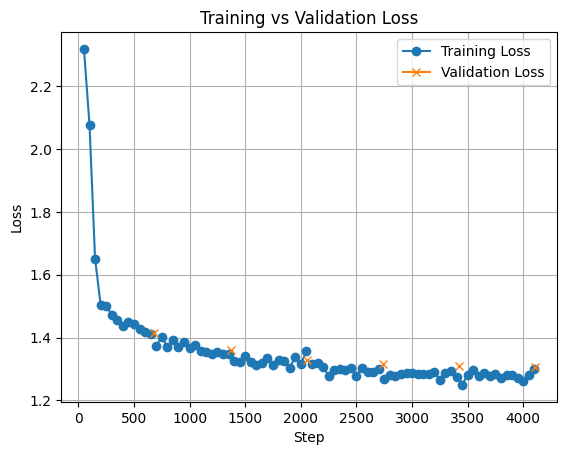

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)

# Optional: Save to CSV
df.to_csv("/mnt/data/Fifth Implementation/loss_history1.csv", index=False)

# Plotting
plt.plot(df["step"], df["loss"], label="Training Loss", marker='o')
plt.plot(df["step"], df["eval_loss"], label="Validation Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# Save Final Model
print("💾 Saving model...")
trainer.save_model(f"{output_dir}/final")
tokenizer.save_pretrained(f"{output_dir}/final")

💾 Saving model...


/home/ec2-user/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /mnt/data/llama2-model - will assume that the vocabulary was not modified.
  warnings.warn(


('/mnt/data/llama2_qa_lora_output6/final/tokenizer_config.json',
 '/mnt/data/llama2_qa_lora_output6/final/special_tokens_map.json',
 '/mnt/data/llama2_qa_lora_output6/final/tokenizer.model',
 '/mnt/data/llama2_qa_lora_output6/final/added_tokens.json',
 '/mnt/data/llama2_qa_lora_output6/final/tokenizer.json')

In [13]:
def clean_prediction(raw_text):
    answer = raw_text.split("[/INST]")[-1].strip()
    answer = re.sub(r"[^\w\s\-.,:/()]", "", answer)

    # Clip to first sentence-ending punctuation
    sentence_end = re.search(r'[.?!]', answer)
    if sentence_end:
        answer = answer[:sentence_end.end()]

    return answer.strip()

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, StoppingCriteria, StoppingCriteriaList
from datasets import Dataset
import evaluate
import pandas as pd
from tqdm import tqdm
import re

# Reload model and tokenizer
model_path = "/mnt/data/llama2_qa_lora_output6/final" 
print("🧠 Loading fine-tuned model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16
).to("cuda")

# Define a custom stopping criteria
class StopOnNewline(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        return input_ids[0, -1] == 13 # Token ID for newline

# --- Create the pipeline ---
qa_pipeline = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer
)

# Load the test dataset.

def extract_prompt_and_answer(entry):
    try:
        text = entry["text"]
        parts = text.split("[/INST]")
        prompt = parts[0] + "[/INST]"
        reference = parts[1].strip().replace("</s>", "")
        return {"prompt": prompt, "reference": reference}
    except Exception:
        return {"prompt": "", "reference": ""}

print("📝 Processing test set...")
processed = [extract_prompt_and_answer(ex) for ex in test_dataset]
processed = [ex for ex in processed if ex["prompt"].strip() and ex["reference"].strip()]

# Inference
print("🔮 Generating predictions with aggressive post-processing...")
predictions = []
batch_size = 4

for i in tqdm(range(0, len(processed), batch_size)):
    batch_prompts = [ex["prompt"] for ex in processed[i:i + batch_size]]
    
    batch_outputs = qa_pipeline(
        batch_prompts, 
        max_new_tokens=40,
        do_sample=False,
        eos_token_id=tokenizer.encode("</s>")[0],
        pad_token_id=tokenizer.eos_token_id
    )

    for out in batch_outputs:
        gen_text = out[0]["generated_text"]
        cleaned_answer = clean_prediction(gen_text)
        predictions.append(cleaned_answer)
# Evaluation using SQuAD metric
print("📊 Calculating metrics...")
references = [ex["reference"] for ex in processed]
squad_metric = evaluate.load("squad")

formatted_preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
formatted_refs = [{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(references)]

results = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

rouge_result = rouge.compute(predictions=predictions, references=references)
bleu_result = bleu.compute(predictions=predictions, references=references)

print(f"🟩 ROUGE-L: {rouge_result['rougeL']:.2f}")
print(f"🟦 BLEU: {bleu_result['bleu']:.2f}")
print(f"\n✅ Exact Match (EM): {results['exact_match']:.2f}")
print(f"📈 F1 Score: {results['f1']:.2f}")

# Save Detailed CSV
df = pd.DataFrame({
    "id": list(range(len(predictions))),
    "prompt": [ex["prompt"] for ex in processed],
    "reference": references,
    "prediction": predictions
})
df["exact_match"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["exact_match"] for i in range(len(predictions))]
df["f1"] = [squad_metric.compute(predictions=[formatted_preds[i]], references=[formatted_refs[i]])["f1"] for i in range(len(predictions))]
csv_path = "/mnt/data/Fifth Implementation/test_dataset_eval_results_FINAL.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Detailed test set results saved to: {csv_path}")

🧠 Loading fine-tuned model and tokenizer...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


📝 Processing test set...
🔮 Generating predictions with aggressive post-processing...


  0%|                                                   | 0/228 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
  0%|▏                                          | 1/228 [00:06<25:23,  6.71s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` 

📊 Calculating metrics...
🟩 ROUGE-L: 0.50
🟦 BLEU: 0.23

✅ Exact Match (EM): 18.64
📈 F1 Score: 50.65
✅ Detailed test set results saved to: /mnt/data/Fifth Implementation/test_dataset_eval_results_FINAL.csv
